In [1]:
# Environment Setup
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip /content/chest-xray-pneumonia.zip -d /content/

Mounted at /content/drive


Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0445-0001.jpeg  


In [2]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

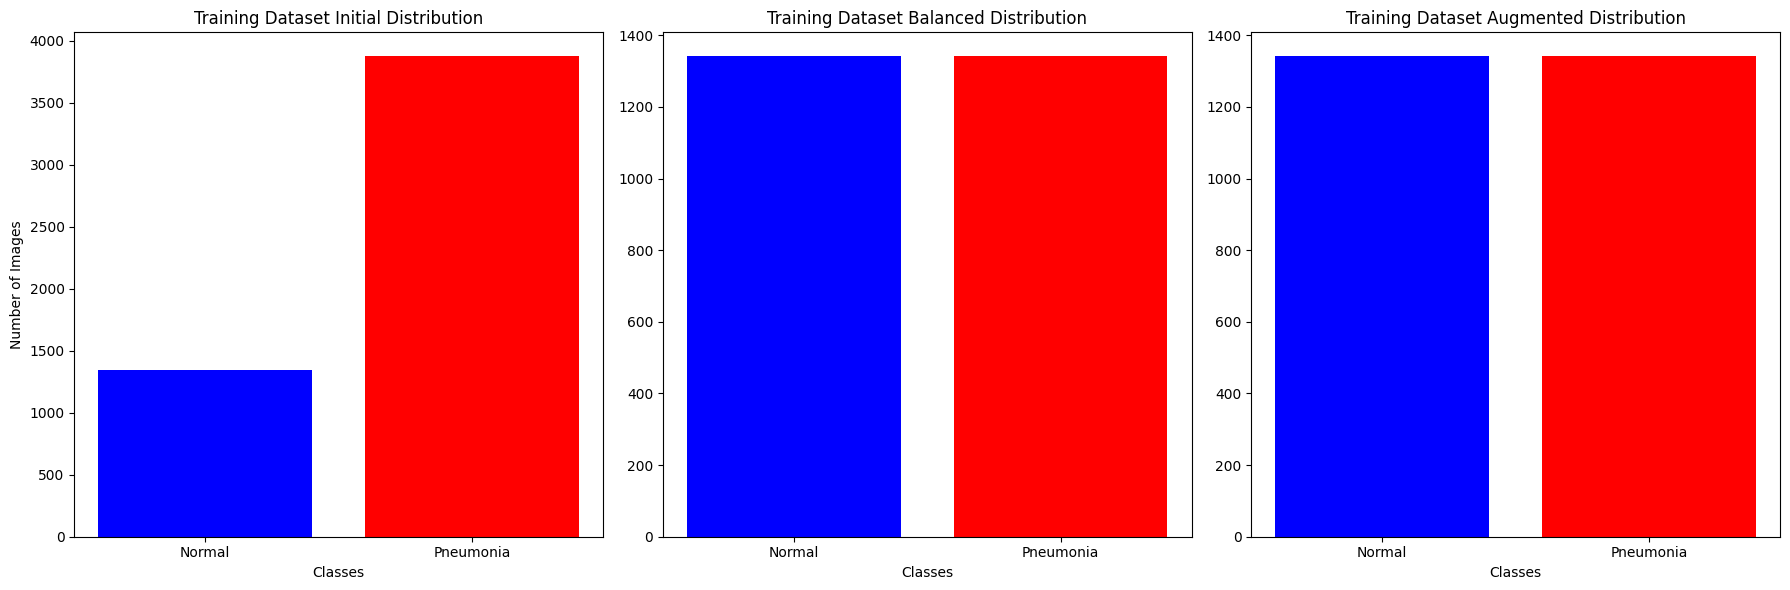

In [3]:
# Define Paths
train_dir = '/content/chest_xray/train/'
test_dir = '/content/chest_xray/test/'
val_dir = '/content/chest_xray/val/'

# Balance Dataset Function
def balance_classes(image_paths, labels):
    normal_paths = [path for path, label in zip(image_paths, labels) if label == 0]
    pneumonia_paths = [path for path, label in zip(image_paths, labels) if label == 1]

    if len(normal_paths) < len(pneumonia_paths):
        balanced_paths = normal_paths + pneumonia_paths[:len(normal_paths)]
        balanced_labels = [0] * len(normal_paths) + [1] * len(normal_paths)
    else:
        balanced_paths = pneumonia_paths + normal_paths[:len(pneumonia_paths)]
        balanced_labels = [1] * len(pneumonia_paths) + [0] * len(pneumonia_paths)

    return balanced_paths, balanced_labels

# Custom Dataset Class
class ChestXrayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load and Balance Datasets
def load_image_paths_and_labels(base_dir):
    image_paths = glob.glob(os.path.join(base_dir, '*', '*.jpeg'))
    labels = [1 if 'PNEUMONIA' in path else 0 for path in image_paths]
    return image_paths, labels

train_image_paths, train_labels = load_image_paths_and_labels(train_dir)
train_image_paths_balanced, train_labels_balanced = balance_classes(train_image_paths, train_labels)

val_image_paths, val_labels = load_image_paths_and_labels(val_dir)
test_image_paths, test_labels = load_image_paths_and_labels(test_dir)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Data Augmentation for Training Set
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Datasets
train_dataset = ChestXrayDataset(train_image_paths_balanced, train_labels_balanced, transform=augment_transform)
val_dataset = ChestXrayDataset(val_image_paths, val_labels, transform=transform)
test_dataset = ChestXrayDataset(test_image_paths, test_labels, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to visualize dataset distribution
def visualize_dataset_distribution(original_labels, balanced_labels, augmented_dataset, dataset_name):
    # Initial Counts
    initial_counts = Counter(original_labels)
    balanced_counts = Counter(balanced_labels)
    augmented_counts = Counter(augmented_dataset.labels)

    classes = ['Normal', 'Pneumonia']

    initial_counts_list = [initial_counts[0], initial_counts[1]]
    balanced_counts_list = [balanced_counts[0], balanced_counts[1]]
    augmented_counts_list = [augmented_counts[0], augmented_counts[1]]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].bar(classes, initial_counts_list, color=['blue', 'red'])
    axs[0].set_title(f'{dataset_name} Dataset Initial Distribution')
    axs[0].set_xlabel('Classes')
    axs[0].set_ylabel('Number of Images')

    axs[1].bar(classes, balanced_counts_list, color=['blue', 'red'])
    axs[1].set_title(f'{dataset_name} Dataset Balanced Distribution')
    axs[1].set_xlabel('Classes')

    axs[2].bar(classes, augmented_counts_list, color=['blue', 'red'])
    axs[2].set_title(f'{dataset_name} Dataset Augmented Distribution')
    axs[2].set_xlabel('Classes')

    plt.tight_layout()
    plt.show()

# Visualize the training dataset
visualize_dataset_distribution(
    train_labels,                    # Original labels
    train_labels_balanced,           # Balanced labels
    train_dataset,                   # Augmented dataset
    'Training'
)


In [4]:
# Model Definition
class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, **kwargs):
        super(CustomTransformerEncoderLayer, self).__init__(d_model, nhead, **kwargs)
        self.attn_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        src2, attn_weights = self.self_attn(src, src, src, attn_mask=src_mask,
                                            key_padding_mask=src_key_padding_mask, need_weights=True, is_causal=is_causal)
        self.attn_weights = attn_weights
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class ConvolutionalVisionTransformer(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvolutionalVisionTransformer, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 128, 3)
        self.layer2 = self._make_layer(128, 256, 4, stride=2)
        self.layer3 = self._make_layer(256, 512, 6, stride=2)
        self.layer4 = self._make_layer(512, 1024, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.transformer = nn.TransformerEncoder(
            CustomTransformerEncoderLayer(d_model=1024, nhead=8), num_layers=8)
        self.fc = nn.Linear(1024, num_classes)
        self.attn_weights = None  # Initialize attention weights

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x)
        self.attn_weights = self.transformer.layers[-1].attn_weights  # Get attention weights from the last layer
        x = x.squeeze(1)
        x = self.fc(x)
        return x

    def get_attention_weights(self):
        return self.attn_weights

model = ConvolutionalVisionTransformer(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Initialize SummaryWriter
writer = SummaryWriter()

# Training Function
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, checkpoint_interval=5, patience=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "train_precision": [],
        "val_precision": [],
        "train_recall": [],
        "val_recall": [],
        "train_f1": [],
        "val_f1": [],
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            all_labels = []
            all_preds = []

            # Iterate over data.
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_precision = precision_score(all_labels, all_preds, average='macro')
            epoch_recall = recall_score(all_labels, all_preds, average='macro')
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}')

            # Store metrics in history
            if phase == 'train':
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
                history["train_precision"].append(epoch_precision)
                history["train_recall"].append(epoch_recall)
                history["train_f1"].append(epoch_f1)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_precision"].append(epoch_precision)
                history["val_recall"].append(epoch_recall)
                history["val_f1"].append(epoch_f1)

            # Tensorboard logging
            writer.add_scalar(f'{phase} loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase} accuracy', epoch_acc, epoch)
            writer.add_scalar(f'{phase} precision', epoch_precision, epoch)
            writer.add_scalar(f'{phase} recall', epoch_recall, epoch)
            writer.add_scalar(f'{phase} f1', epoch_f1, epoch)

            # Deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        if epoch % checkpoint_interval == 0:
            checkpoint_path = f'/content/drive/My Drive/equalsized_7_25_{epoch}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model checkpoint saved at {checkpoint_path}')

        # Early stopping
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

        # Learning rate scheduler step
        scheduler.step()

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Initialize the scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

# Train the model and get the history
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50, checkpoint_interval=1, patience=10)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0/49
----------
train Loss: 0.6551 Acc: 0.6573 Precision: 0.6573 Recall: 0.6573 F1: 0.6573
val Loss: 0.7890 Acc: 0.6250 Precision: 0.6333 Recall: 0.6250 F1: 0.6190
Model checkpoint saved at /content/drive/My Drive/equalsized_7_25_0.pth
Epoch 1/49
----------
train Loss: 0.5129 Acc: 0.7744 Precision: 0.7753 Recall: 0.7744 F1: 0.7742
val Loss: 0.6400 Acc: 0.6250 Precision: 0.6667 Recall: 0.6250 F1: 0.6000
Model checkpoint saved at /content/drive/My Drive/equalsized_7_25_1.pth
Epoch 2/49
----------
train Loss: 0.3665 Acc: 0.8602 Precision: 0.8621 Recall: 0.8602 F1: 0.8600
val Loss: 0.5597 Acc: 0.6875 Precision: 0.6905 Recall: 0.6875 F1: 0.6863
Model checkpoint saved at /content/drive/My Drive/equalsized_7_25_2.pth
Epoch 3/49
----------
train Loss: 0.4267 Acc: 0.8337 Precision: 0.8338 Recall: 0.8337 F1: 0.8337
val Loss: 0.6486 Acc: 0.6250 Precision: 0.6250 Recall: 0.6250 F1: 0.6250
Model checkpoint saved at /content/drive/My Drive/equalsized_7_25_3.pth
Epoch 4/49
----------
train Loss

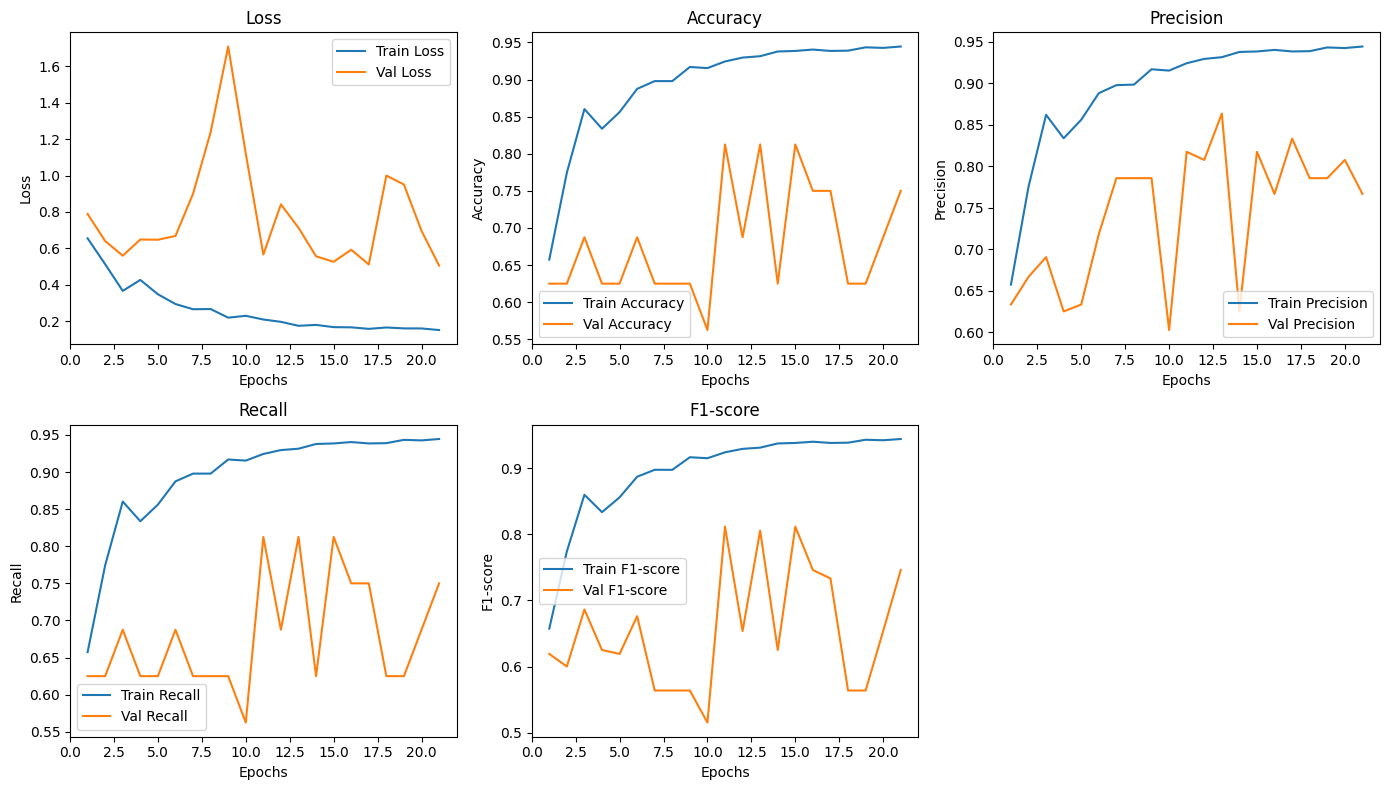

Test Accuracy: 0.9615
Test Precision: 0.9583
Test Recall: 0.9598
Test F1-score: 0.9590


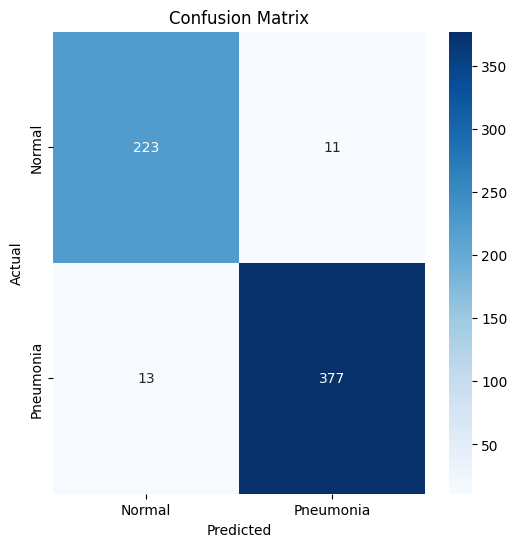

In [5]:
from sklearn.metrics import confusion_matrix

# Plotting Function
def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    # Plot accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    # Plot precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history["train_precision"], label="Train Precision")
    plt.plot(epochs, history["val_precision"], label="Val Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.title("Precision")

    # Plot recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history["train_recall"], label="Train Recall")
    plt.plot(epochs, history["val_recall"], label="Val Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.title("Recall")

    # Plot F1-score
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history["train_f1"], label="Train F1-score")
    plt.plot(epochs, history["val_f1"], label="Val F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("F1-score")
    plt.legend()
    plt.title("F1-score")

    plt.tight_layout()
    plt.show()

plot_metrics(history)

# Evaluate Function
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    return all_labels, all_preds, accuracy, precision, recall, f1

# Evaluate the model on the test set
all_labels, all_preds, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader)

# Confusion Matrix
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
class_names = ['Normal', 'Pneumonia']
plot_confusion_matrix(all_labels, all_preds, class_names)

In [12]:
import torch

# Path to save the trained model
model_save_path = f'/content/drive/My Drive/trained_model_96.pth'

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)


In [11]:
from google.colab import files

# Download the saved model file
files.download(model_save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Download the saved model file
files.download(model_save_path)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Test Accuracy: 0.8766
Test Precision: 0.8663
Test Recall: 0.8833
Test F1-score: 0.8718


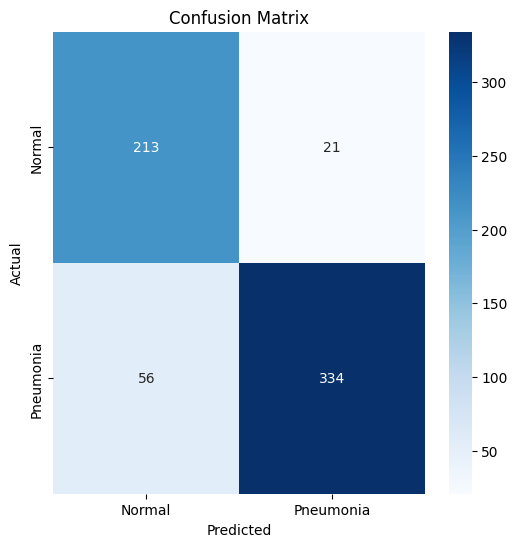

In [ ]:
from sklearn.metrics import confusion_matrix
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the model
model = ConvolutionalVisionTransformer()

# Load the model state dictionary
model.load_state_dict(torch.load('/content/drive/My Drive/equalsized_7_24_2_14.pth'))
model.to(device)  # Ensure the model is on the correct device

# Plotting Function
def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    # Plot accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    # Plot precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history["train_precision"], label="Train Precision")
    plt.plot(epochs, history["val_precision"], label="Val Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.title("Precision")

    # Plot recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history["train_recall"], label="Train Recall")
    plt.plot(epochs, history["val_recall"], label="Val Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.title("Recall")

    # Plot F1-score
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history["train_f1"], label="Train F1-score")
    plt.plot(epochs, history["val_f1"], label="Val F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("F1-score")
    plt.legend()
    plt.title("F1-score")

    plt.tight_layout()
    plt.show()

# Assuming history is a dictionary with relevant data
# plot_metrics(history)  # Uncomment this when history is available

# Evaluate Function
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    return all_labels, all_preds, accuracy, precision, recall, f1

# Assuming test_loader is already defined
all_labels, all_preds, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader)

# Confusion Matrix
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
class_names = ['Normal', 'Pneumonia']
plot_confusion_matrix(all_labels, all_preds, class_names)

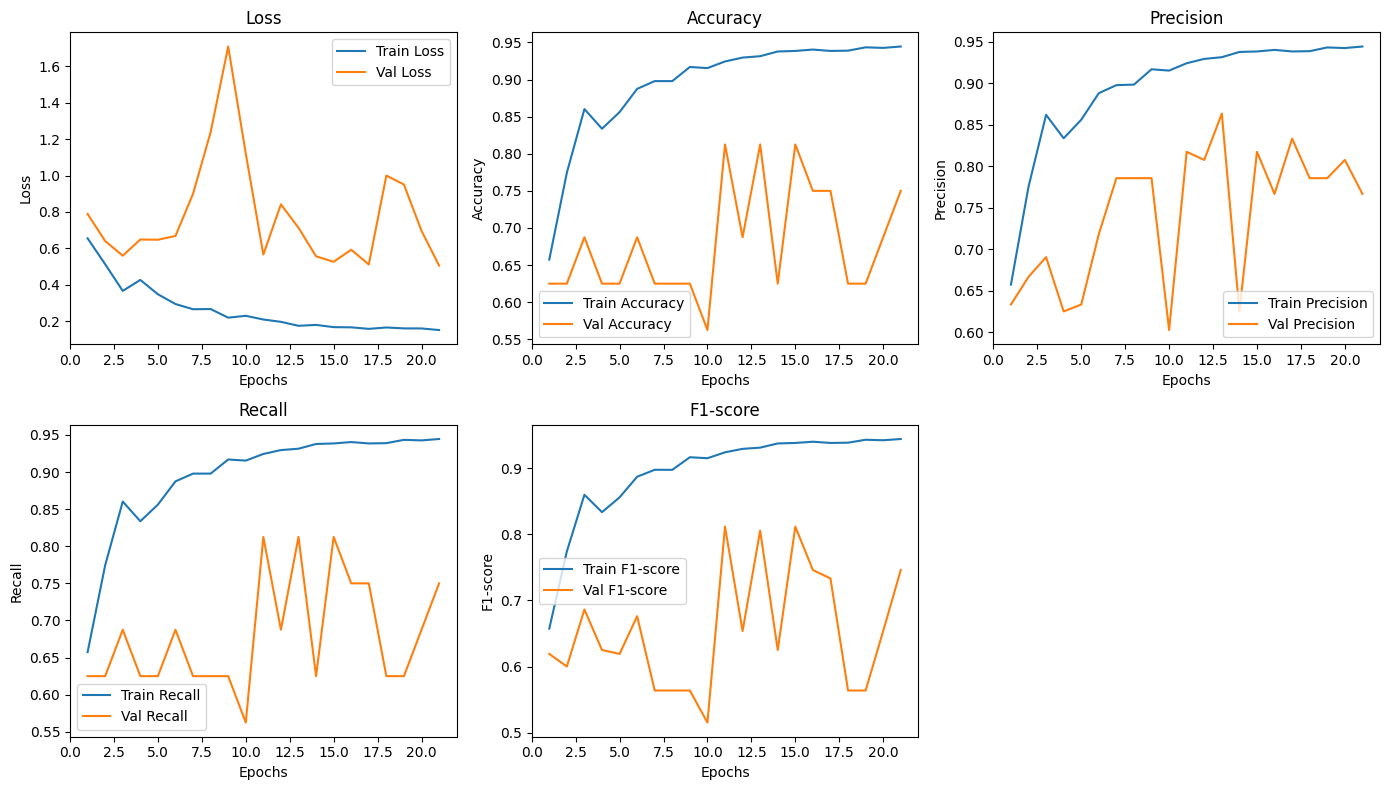

Test Accuracy: 0.9615
Test Precision: 0.9583
Test Recall: 0.9598
Test F1-score: 0.9590


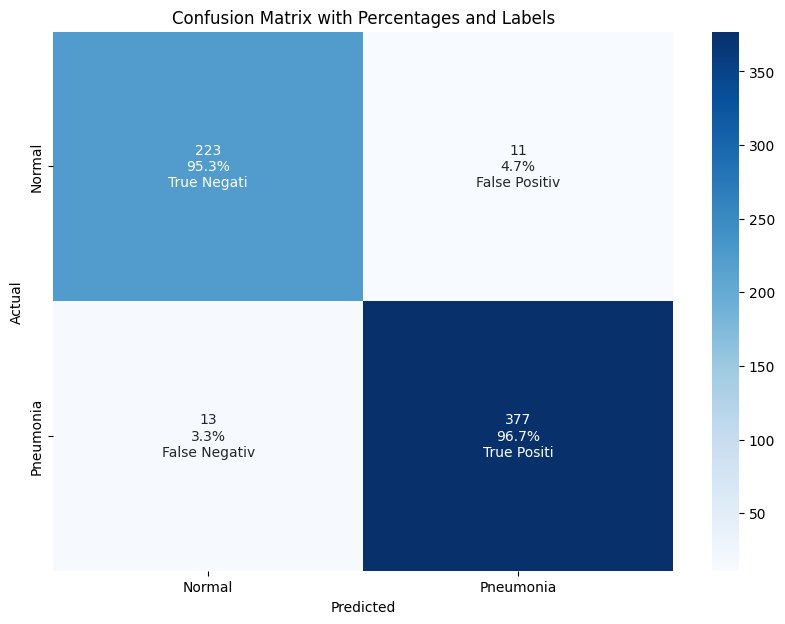

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Plotting Function
def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    # Plot accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    # Plot precision
    plt.subplot(2, 3, 3)
    plt.plot(epochs, history["train_precision"], label="Train Precision")
    plt.plot(epochs, history["val_precision"], label="Val Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.title("Precision")

    # Plot recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, history["train_recall"], label="Train Recall")
    plt.plot(epochs, history["val_recall"], label="Val Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.title("Recall")

    # Plot F1-score
    plt.subplot(2, 3, 5)
    plt.plot(epochs, history["train_f1"], label="Train F1-score")
    plt.plot(epochs, history["val_f1"], label="Val F1-score")
    plt.xlabel("Epochs")
    plt.ylabel("F1-score")
    plt.legend()
    plt.title("F1-score")

    plt.tight_layout()
    plt.show()

# Evaluate Function
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    return all_labels, all_preds, accuracy, precision, recall, f1

# Confusion Matrix
def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    annot = np.empty_like(cm).astype(str)

    for i, j in np.ndindex(cm.shape):
        if i == j:
            s = cm[i, j]
            perc = cm_perc[i, j]
            annot[i, j] = f'{s}\n{perc:.1f}%\nTrue Positive' if i == 1 else f'{s}\n{perc:.1f}%\nTrue Negative'
        elif i < j:
            s = cm[i, j]
            perc = cm_perc[i, j]
            annot[i, j] = f'{s}\n{perc:.1f}%\nFalse Positive'
        else:
            s = cm[i, j]
            perc = cm_perc[i, j]
            annot[i, j] = f'{s}\n{perc:.1f}%\nFalse Negative'

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix with Percentages and Labels')
    plt.show()

# Plot metrics
plot_metrics(history)

# Evaluate the model on the test set
all_labels, all_preds, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader)

# Plot confusion matrix
class_names = ['Normal', 'Pneumonia']
plot_confusion_matrix(all_labels, all_preds, class_names)
